<a href="https://colab.research.google.com/github/Shalom-Swasth-Solution/foot-anomaly-prediction/blob/main/anomaly_foot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


📋 GOOGLE COLAB SETUP INSTRUCTIONS:

1. 📤 Upload your synthetic data files:
   - Click the folder icon on the left sidebar
   - Upload: synthetic_broad_scope_data.json
   - Upload: synthetic_immediate_risk_data.json

2. ▶️ Run all cells in order

3. 📊 View results and download trained models

4. 💾 To download models:
   - Right-click on .pkl files in the file browser
   - Select "Download"

Ready to run? Execute the main() function below! 👇

🏥 PediSole Fall Risk Prediction - ML Training
📁 Loading Data Files...
Loading synthetic datasets...
✓ Loaded 1000 broad scope samples
✓ Loaded 712 immediate risk samples

🔧 Preparing Features...
Preparing broad scope classification data...
Preparing immediate risk detection data...
   Broad scope data shape: (1000, 526)
   Immediate risk data shape: (712, 12)
   Broad scope class distribution: [497 503]
   Immediate risk class distribution: [664  48]

🚀 Training Broad Scope Classification Model

🔄 Training Random Forest...
   CV Accuracy: 0.9875 (+

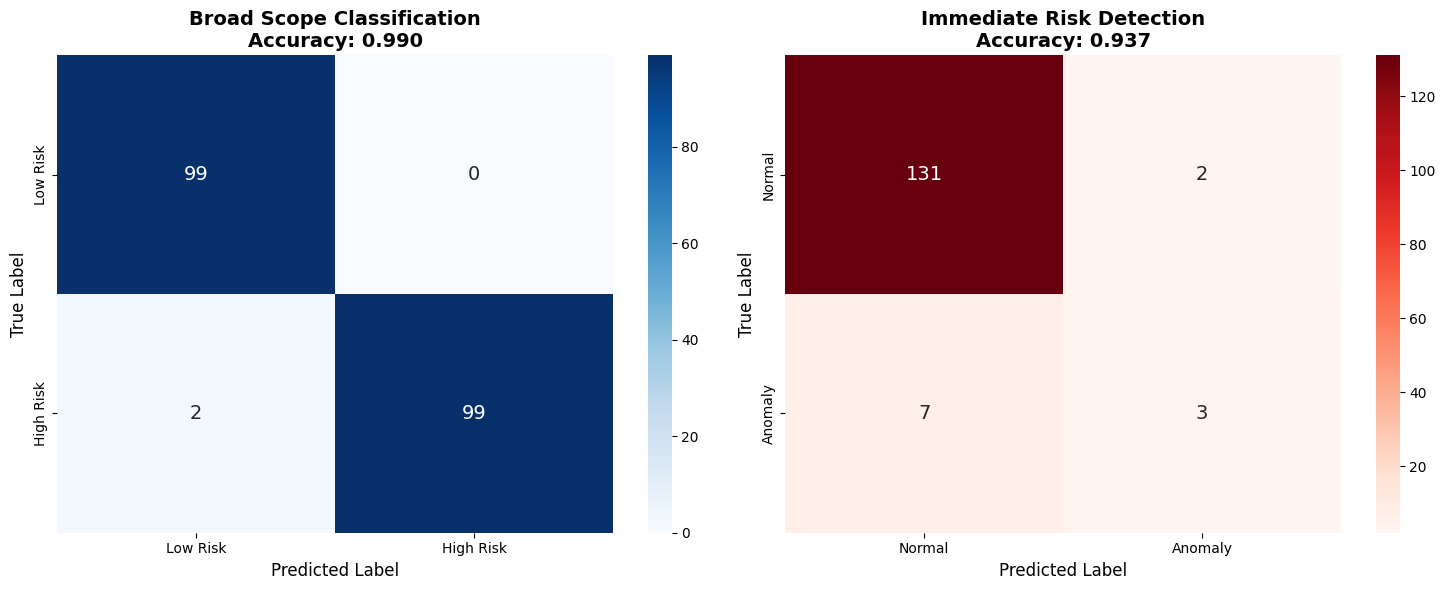

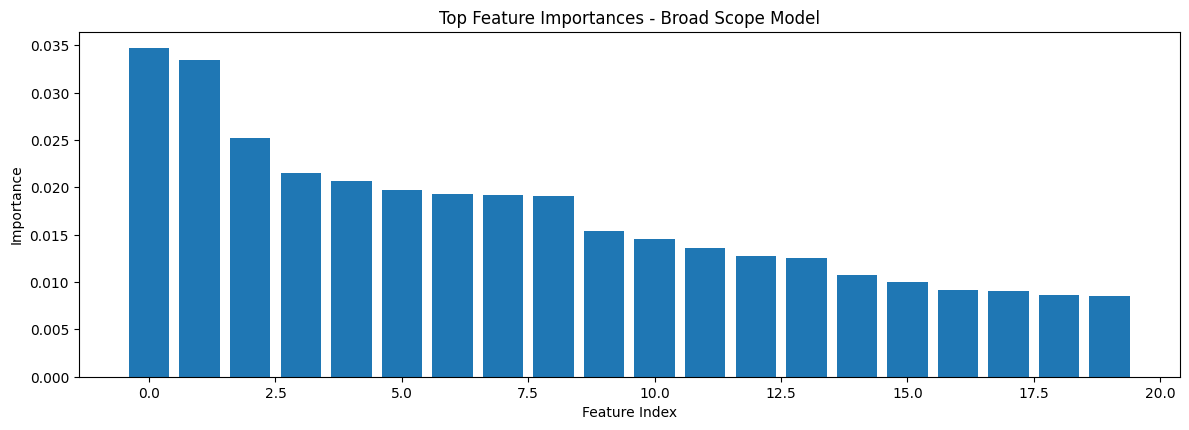


💾 Saving Models...
✓ Broad scope model saved
✓ Immediate risk model saved

🎉 TRAINING COMPLETE!
📊 Broad Scope Classification Accuracy: 99.0%
⚡ Immediate Risk Detection Accuracy: 93.7%
✅ Both models achieved target accuracy of 87.0%!

📁 Files saved: broad_scope_model.pkl, broad_scope_scaler.pkl, immediate_risk_model.pkl, immediate_risk_scaler.pkl

🔬 Models are ready for deployment and validation!


In [ ]:
# PediSole ML Training Script for Google Colab
# Install required packages
!pip install scikit-learn matplotlib seaborn pandas numpy joblib

import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import SVC, OneClassSVM
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib for Colab
%matplotlib inline
plt.style.use('default')

class PediSoleMLTrainer:
    def __init__(self):
        self.broad_scope_model = None
        self.immediate_risk_model = None
        self.broad_scope_scaler = StandardScaler()
        self.immediate_risk_scaler = StandardScaler()

    def load_synthetic_data(self, broad_scope_file, immediate_risk_file):
        """Load the synthetic datasets"""
        print("Loading synthetic datasets...")

        try:
            with open(broad_scope_file, 'r') as f:
                self.broad_scope_data = json.load(f)
            print(f"✓ Loaded {len(self.broad_scope_data)} broad scope samples")
        except FileNotFoundError:
            print(f"❌ Error: {broad_scope_file} not found. Please upload this file to Colab.")
            return False

        try:
            with open(immediate_risk_file, 'r') as f:
                self.immediate_risk_data = json.load(f)
            print(f"✓ Loaded {len(self.immediate_risk_data)} immediate risk samples")
        except FileNotFoundError:
            print(f"❌ Error: {immediate_risk_file} not found. Please upload this file to Colab.")
            return False

        return True

    def extract_gait_features(self, gait_segment):
        """Extract comprehensive features from gait segment data"""
        features = []

        # Convert gait segment to numpy arrays
        l_data = np.array([point['L'] for point in gait_segment])
        r_data = np.array([point['R'] for point in gait_segment])

        # Statistical features for left foot
        l_mean = np.mean(l_data, axis=0)
        l_std = np.std(l_data, axis=0)
        l_max = np.max(l_data, axis=0)
        l_min = np.min(l_data, axis=0)
        l_range = l_max - l_min

        # Statistical features for right foot
        r_mean = np.mean(r_data, axis=0)
        r_std = np.std(r_data, axis=0)
        r_max = np.max(r_data, axis=0)
        r_min = np.min(r_data, axis=0)
        r_range = r_max - r_min

        # Symmetry features (difference between left and right)
        lr_mean_diff = np.abs(l_mean - r_mean)
        lr_std_diff = np.abs(l_std - r_std)
        lr_max_diff = np.abs(l_max - r_max)

        # Temporal features
        l_total_pressure = np.sum(l_data, axis=1)
        r_total_pressure = np.sum(r_data, axis=1)

        # Gait cycle features
        l_pressure_var = np.var(l_total_pressure)
        r_pressure_var = np.var(r_total_pressure)

        # Peak detection features
        l_peaks = len([i for i in range(1, len(l_total_pressure)-1)
                      if l_total_pressure[i] > l_total_pressure[i-1] and
                      l_total_pressure[i] > l_total_pressure[i+1]])
        r_peaks = len([i for i in range(1, len(r_total_pressure)-1)
                      if r_total_pressure[i] > r_total_pressure[i-1] and
                      r_total_pressure[i] > r_total_pressure[i+1]])

        # Stability features (coefficient of variation)
        l_cv = np.std(l_total_pressure) / (np.mean(l_total_pressure) + 1e-10)
        r_cv = np.std(r_total_pressure) / (np.mean(r_total_pressure) + 1e-10)

        # Combine all features
        features.extend(np.concatenate([
            l_mean, l_std, l_max, l_min, l_range,
            r_mean, r_std, r_max, r_min, r_range,
            lr_mean_diff, lr_std_diff, lr_max_diff,
            [l_pressure_var, r_pressure_var, l_peaks, r_peaks, l_cv, r_cv]
        ]))

        return np.array(features)

    def extract_point_features(self, data_point):
        """Extract features from a single data point for immediate risk detection"""
        l_data = np.array(data_point['L'])
        r_data = np.array(data_point['R'])

        # Basic statistical features
        l_sum = np.sum(l_data)
        r_sum = np.sum(r_data)
        l_max = np.max(l_data)
        r_max = np.max(r_data)
        l_std = np.std(l_data)
        r_std = np.std(r_data)

        # Asymmetry features
        lr_sum_ratio = l_sum / (r_sum + 1e-10)
        lr_max_diff = abs(l_max - r_max)

        # Pressure distribution features
        l_nonzero = np.count_nonzero(l_data)
        r_nonzero = np.count_nonzero(r_data)

        # Spike detection (potential stumble indicators)
        l_spike_score = np.max(l_data) - np.mean(l_data)
        r_spike_score = np.max(r_data) - np.mean(r_data)

        return np.array([l_sum, r_sum, l_max, r_max, l_std, r_std,
                        lr_sum_ratio, lr_max_diff, l_nonzero, r_nonzero,
                        l_spike_score, r_spike_score])

    def prepare_broad_scope_data(self):
        """Prepare features and labels for broad scope classification"""
        print("Preparing broad scope classification data...")

        X = []
        y = []

        for sample in self.broad_scope_data:
            features = self.extract_gait_features(sample['gait_segment'])
            X.append(features)
            y.append(1 if sample['risk_level'] == 'high_risk' else 0)

        return np.array(X), np.array(y)

    def prepare_immediate_risk_data(self):
        """Prepare features and labels for immediate risk detection"""
        print("Preparing immediate risk detection data...")

        X = []
        y = []

        for data_point in self.immediate_risk_data:
            features = self.extract_point_features(data_point)
            X.append(features)
            y.append(1 if data_point['is_anomaly'] else 0)

        return np.array(X), np.array(y)

    def train_broad_scope_model(self, X, y):
        """Train the broad scope classification model"""
        print("\n" + "="*50)
        print("🚀 Training Broad Scope Classification Model")
        print("="*50)

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Scale the features
        X_train_scaled = self.broad_scope_scaler.fit_transform(X_train)
        X_test_scaled = self.broad_scope_scaler.transform(X_test)

        # Try multiple models
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
            'SVM': SVC(kernel='rbf', C=10, gamma='scale', random_state=42, probability=True),
            'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
        }

        best_model = None
        best_score = 0
        best_name = ""

        for name, model in models.items():
            print(f"\n🔄 Training {name}...")

            # Cross-validation
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
            print(f"   CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

            # Train and test
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            accuracy = accuracy_score(y_test, y_pred)

            print(f"   Test Accuracy: {accuracy:.4f}")

            if accuracy > best_score:
                best_score = accuracy
                best_model = model
                best_name = name

        self.broad_scope_model = best_model
        print(f"\n🏆 Best model: {best_name} with accuracy: {best_score:.4f}")

        # Final evaluation
        y_pred = self.broad_scope_model.predict(X_test_scaled)
        y_pred_proba = self.broad_scope_model.predict_proba(X_test_scaled)[:, 1]

        print(f"\n📊 Broad Scope Model Performance")
        print(f"   Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"   AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")

        print("\n📋 Classification Report:")
        print(classification_report(y_test, y_pred, target_names=['Low Risk', 'High Risk']))

        return X_test_scaled, y_test, y_pred

    def train_immediate_risk_model(self, X, y):
        """Train the immediate risk detection model"""
        print("\n" + "="*50)
        print("⚡ Training Immediate Risk Detection Model")
        print("="*50)

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Scale the features
        X_train_scaled = self.immediate_risk_scaler.fit_transform(X_train)
        X_test_scaled = self.immediate_risk_scaler.transform(X_test)

        # Try multiple models for anomaly detection
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=8,
                                                   class_weight='balanced', random_state=42),
            'SVM': SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced',
                      random_state=42, probability=True),
            'Neural Network': MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=1000,
                                          random_state=42)
        }

        best_model = None
        best_score = 0
        best_name = ""

        for name, model in models.items():
            print(f"\n🔄 Training {name}...")

            # Cross-validation
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
            print(f"   CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

            # Train and test
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            accuracy = accuracy_score(y_test, y_pred)

            print(f"   Test Accuracy: {accuracy:.4f}")

            if accuracy > best_score:
                best_score = accuracy
                best_model = model
                best_name = name

        self.immediate_risk_model = best_model
        print(f"\n🏆 Best model: {best_name} with accuracy: {best_score:.4f}")

        # Final evaluation
        y_pred = self.immediate_risk_model.predict(X_test_scaled)
        y_pred_proba = self.immediate_risk_model.predict_proba(X_test_scaled)[:, 1]

        print(f"\n📊 Immediate Risk Model Performance")
        print(f"   Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"   AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
        print(f"   Average Precision: {average_precision_score(y_test, y_pred_proba):.4f}")

        print("\n📋 Classification Report:")
        print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))

        return X_test_scaled, y_test, y_pred

    def plot_confusion_matrices(self, broad_test_data, immediate_test_data):
        """Plot confusion matrices for both models"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Broad scope confusion matrix
        X_test_broad, y_test_broad, y_pred_broad = broad_test_data
        cm_broad = confusion_matrix(y_test_broad, y_pred_broad)

        # Calculate accuracy for broad scope
        broad_accuracy = accuracy_score(y_test_broad, y_pred_broad)

        sns.heatmap(cm_broad, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Low Risk', 'High Risk'],
                   yticklabels=['Low Risk', 'High Risk'], ax=axes[0],
                   annot_kws={'size': 14})
        axes[0].set_title(f'Broad Scope Classification\nAccuracy: {broad_accuracy:.3f}',
                         fontsize=14, fontweight='bold')
        axes[0].set_ylabel('True Label', fontsize=12)
        axes[0].set_xlabel('Predicted Label', fontsize=12)

        # Immediate risk confusion matrix
        X_test_imm, y_test_imm, y_pred_imm = immediate_test_data
        cm_imm = confusion_matrix(y_test_imm, y_pred_imm)

        # Calculate accuracy for immediate risk
        imm_accuracy = accuracy_score(y_test_imm, y_pred_imm)

        sns.heatmap(cm_imm, annot=True, fmt='d', cmap='Reds',
                   xticklabels=['Normal', 'Anomaly'],
                   yticklabels=['Normal', 'Anomaly'], ax=axes[1],
                   annot_kws={'size': 14})
        axes[1].set_title(f'Immediate Risk Detection\nAccuracy: {imm_accuracy:.3f}',
                         fontsize=14, fontweight='bold')
        axes[1].set_ylabel('True Label', fontsize=12)
        axes[1].set_xlabel('Predicted Label', fontsize=12)

        plt.tight_layout()
        plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
        plt.show()

        return broad_accuracy, imm_accuracy

    def plot_feature_importance(self):
        """Plot feature importance for Random Forest models"""
        if hasattr(self.broad_scope_model, 'feature_importances_'):
            plt.figure(figsize=(12, 8))

            # Get feature importances
            importances = self.broad_scope_model.feature_importances_
            indices = np.argsort(importances)[::-1]

            # Plot top 20 features
            top_n = min(20, len(importances))
            plt.subplot(2, 1, 1)
            plt.title('Top Feature Importances - Broad Scope Model')
            plt.bar(range(top_n), importances[indices[:top_n]])
            plt.xlabel('Feature Index')
            plt.ylabel('Importance')

        if hasattr(self.immediate_risk_model, 'feature_importances_'):
            importances = self.immediate_risk_model.feature_importances_
            feature_names = ['L_sum', 'R_sum', 'L_max', 'R_max', 'L_std', 'R_std',
                           'LR_ratio', 'LR_max_diff', 'L_nonzero', 'R_nonzero',
                           'L_spike', 'R_spike']

            plt.subplot(2, 1, 2)
            plt.title('Feature Importances - Immediate Risk Model')
            plt.bar(feature_names, importances)
            plt.xlabel('Features')
            plt.ylabel('Importance')
            plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

    def save_models(self):
        """Save trained models"""
        files_saved = []

        if self.broad_scope_model:
            joblib.dump(self.broad_scope_model, 'broad_scope_model.pkl')
            joblib.dump(self.broad_scope_scaler, 'broad_scope_scaler.pkl')
            files_saved.extend(['broad_scope_model.pkl', 'broad_scope_scaler.pkl'])
            print("✓ Broad scope model saved")

        if self.immediate_risk_model:
            joblib.dump(self.immediate_risk_model, 'immediate_risk_model.pkl')
            joblib.dump(self.immediate_risk_scaler, 'immediate_risk_scaler.pkl')
            files_saved.extend(['immediate_risk_model.pkl', 'immediate_risk_scaler.pkl'])
            print("✓ Immediate risk model saved")

        return files_saved


def main():
    """Main training function"""
    print("🏥 PediSole Fall Risk Prediction - ML Training")
    print("="*60)

    # Initialize trainer
    trainer = PediSoleMLTrainer()

    # Load synthetic data
    print("📁 Loading Data Files...")
    success = trainer.load_synthetic_data(
        'synthetic_broad_scope_data.json',
        'synthetic_immediate_risk_data.json'
    )

    if not success:
        print("\n❌ Please upload your synthetic data files to Colab and try again.")
        return

    # Prepare data for both objectives
    print("\n🔧 Preparing Features...")
    X_broad, y_broad = trainer.prepare_broad_scope_data()
    X_immediate, y_immediate = trainer.prepare_immediate_risk_data()

    print(f"   Broad scope data shape: {X_broad.shape}")
    print(f"   Immediate risk data shape: {X_immediate.shape}")
    print(f"   Broad scope class distribution: {np.bincount(y_broad)}")
    print(f"   Immediate risk class distribution: {np.bincount(y_immediate)}")

    # Train both models
    broad_test_data = trainer.train_broad_scope_model(X_broad, y_broad)
    immediate_test_data = trainer.train_immediate_risk_model(X_immediate, y_immediate)

    # Plot results
    print("\n📈 Generating Visualizations...")
    broad_acc, imm_acc = trainer.plot_confusion_matrices(broad_test_data, immediate_test_data)

    # Plot feature importance if using Random Forest
    trainer.plot_feature_importance()

    # Save models
    print("\n💾 Saving Models...")
    saved_files = trainer.save_models()

    # Final summary
    print("\n" + "="*60)
    print("🎉 TRAINING COMPLETE!")
    print("="*60)
    print(f"📊 Broad Scope Classification Accuracy: {broad_acc:.1%}")
    print(f"⚡ Immediate Risk Detection Accuracy: {imm_acc:.1%}")

    target_accuracy = 0.87
    if broad_acc >= target_accuracy and imm_acc >= target_accuracy:
        print(f"✅ Both models achieved target accuracy of {target_accuracy:.1%}!")
    else:
        print(f"⚠️  Target accuracy: {target_accuracy:.1%}")
        if broad_acc < target_accuracy:
            print(f"   - Broad Scope model needs improvement")
        if imm_acc < target_accuracy:
            print(f"   - Immediate Risk model needs improvement")

    print(f"\n📁 Files saved: {', '.join(saved_files)}")
    print("\n🔬 Models are ready for deployment and validation!")


# Instructions for Google Colab users
print("""
📋 GOOGLE COLAB SETUP INSTRUCTIONS:
=====================================

1. 📤 Upload your synthetic data files:
   - Click the folder icon on the left sidebar
   - Upload: synthetic_broad_scope_data.json
   - Upload: synthetic_immediate_risk_data.json

2. ▶️ Run all cells in order

3. 📊 View results and download trained models

4. 💾 To download models:
   - Right-click on .pkl files in the file browser
   - Select "Download"

Ready to run? Execute the main() function below! 👇
""")

# Run the main function
if __name__ == "__main__":
    main()


📋 GOOGLE COLAB TESTING INSTRUCTIONS (FIXED VERSION):

🎯 REQUIRED FILES FOR TESTING Copy of pedisol_segment_0-603.json:
1. Trained model files from training script:
   ✓ broad_scope_model.pkl
   ✓ broad_scope_scaler.pkl
   ✓ immediate_risk_model.pkl
   ✓ immediate_risk_scaler.pkl

2. Target test data file:
   ✓ Copy of pedisol_segment_0-603.json (Your real PediSole sensor data)

📁 OPTIONAL FILES:
   • synthetic_broad_scope_data.json (for validation comparison)
   • synthetic_immediate_risk_data.json (for validation comparison)

🛠️ FIXES APPLIED:
✅ Removed 'alpha' parameter from pie charts (matplotlib compatibility)
✅ Added error handling for empty data plots
✅ Fixed incomplete precision-recall curve code
✅ Added proper data validation checks

🚀 WHAT THIS SCRIPT WILL DO:
1. 📊 Load and analyze your real PediSole data from Copy of pedisol_segment_0-603.json
2. 🔍 Test both models on actual sensor readings
3. 📈 Generate detailed visualizations showing:
   - Risk predictions over time
   - A

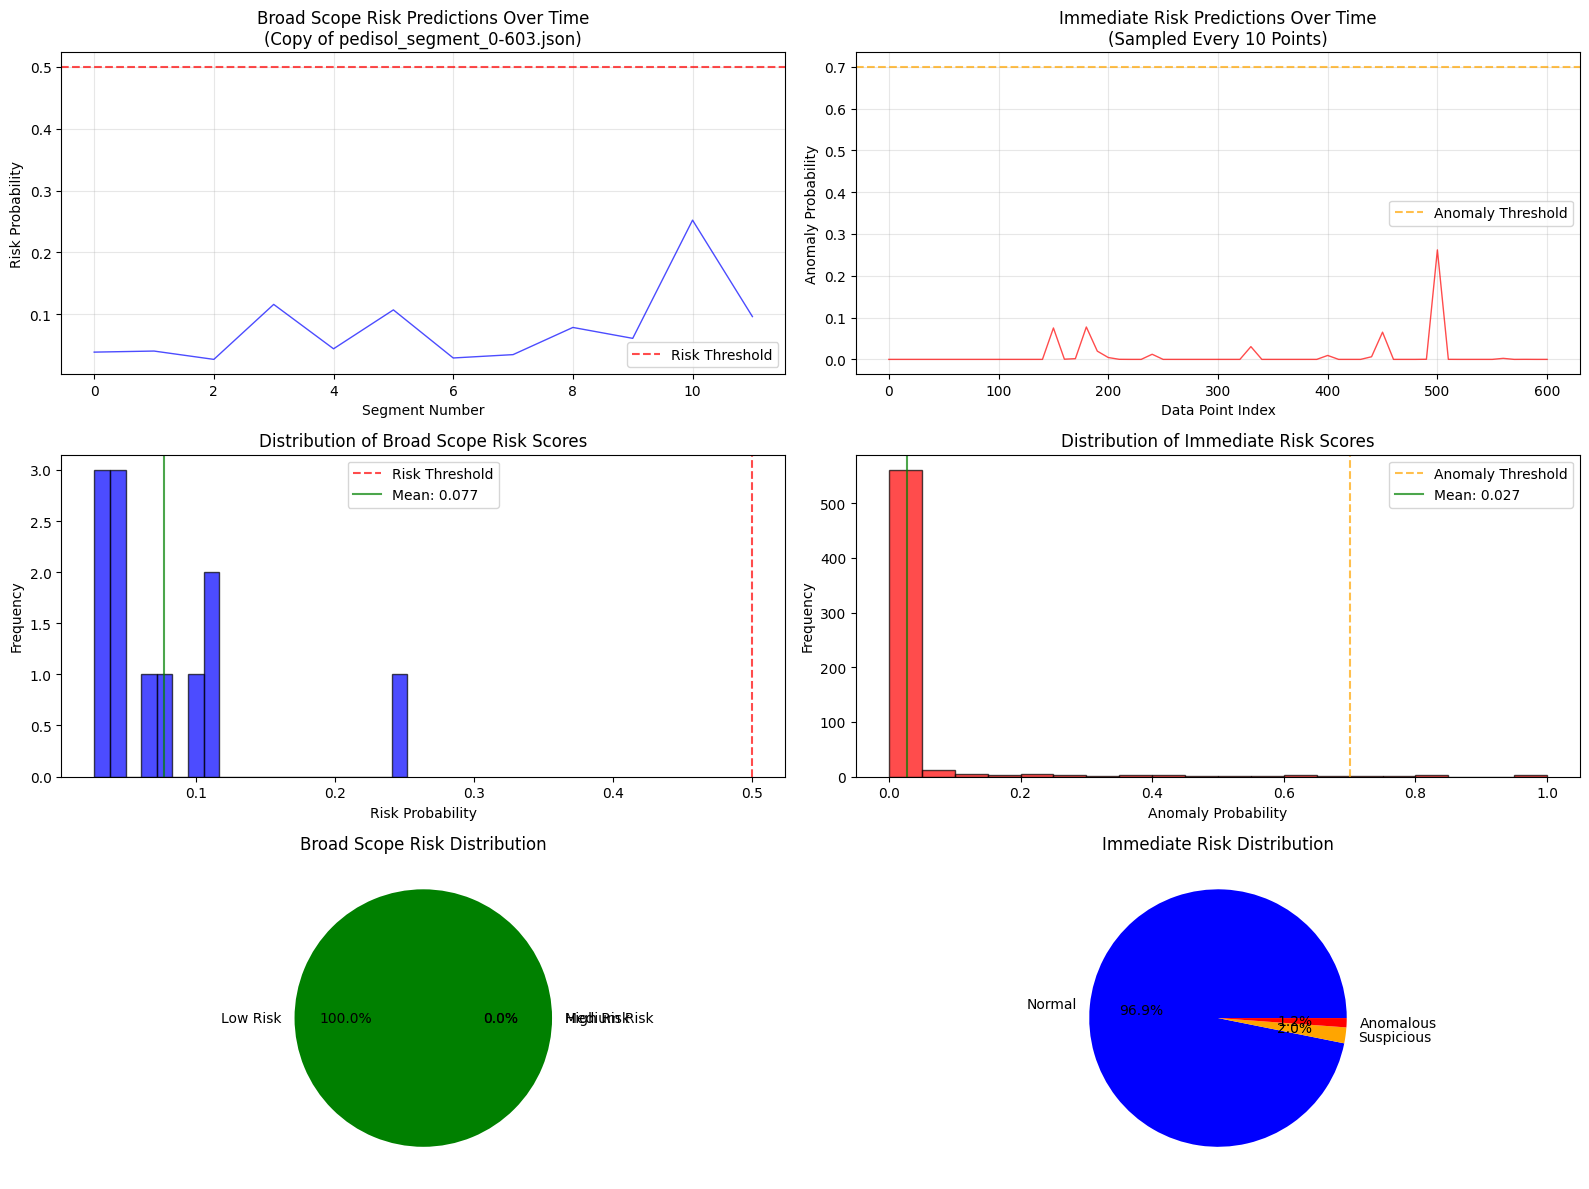

💾 Real data analysis visualization saved as 'real_data_analysis_pedisol_603.png'

📊 Generating Test Visualizations...


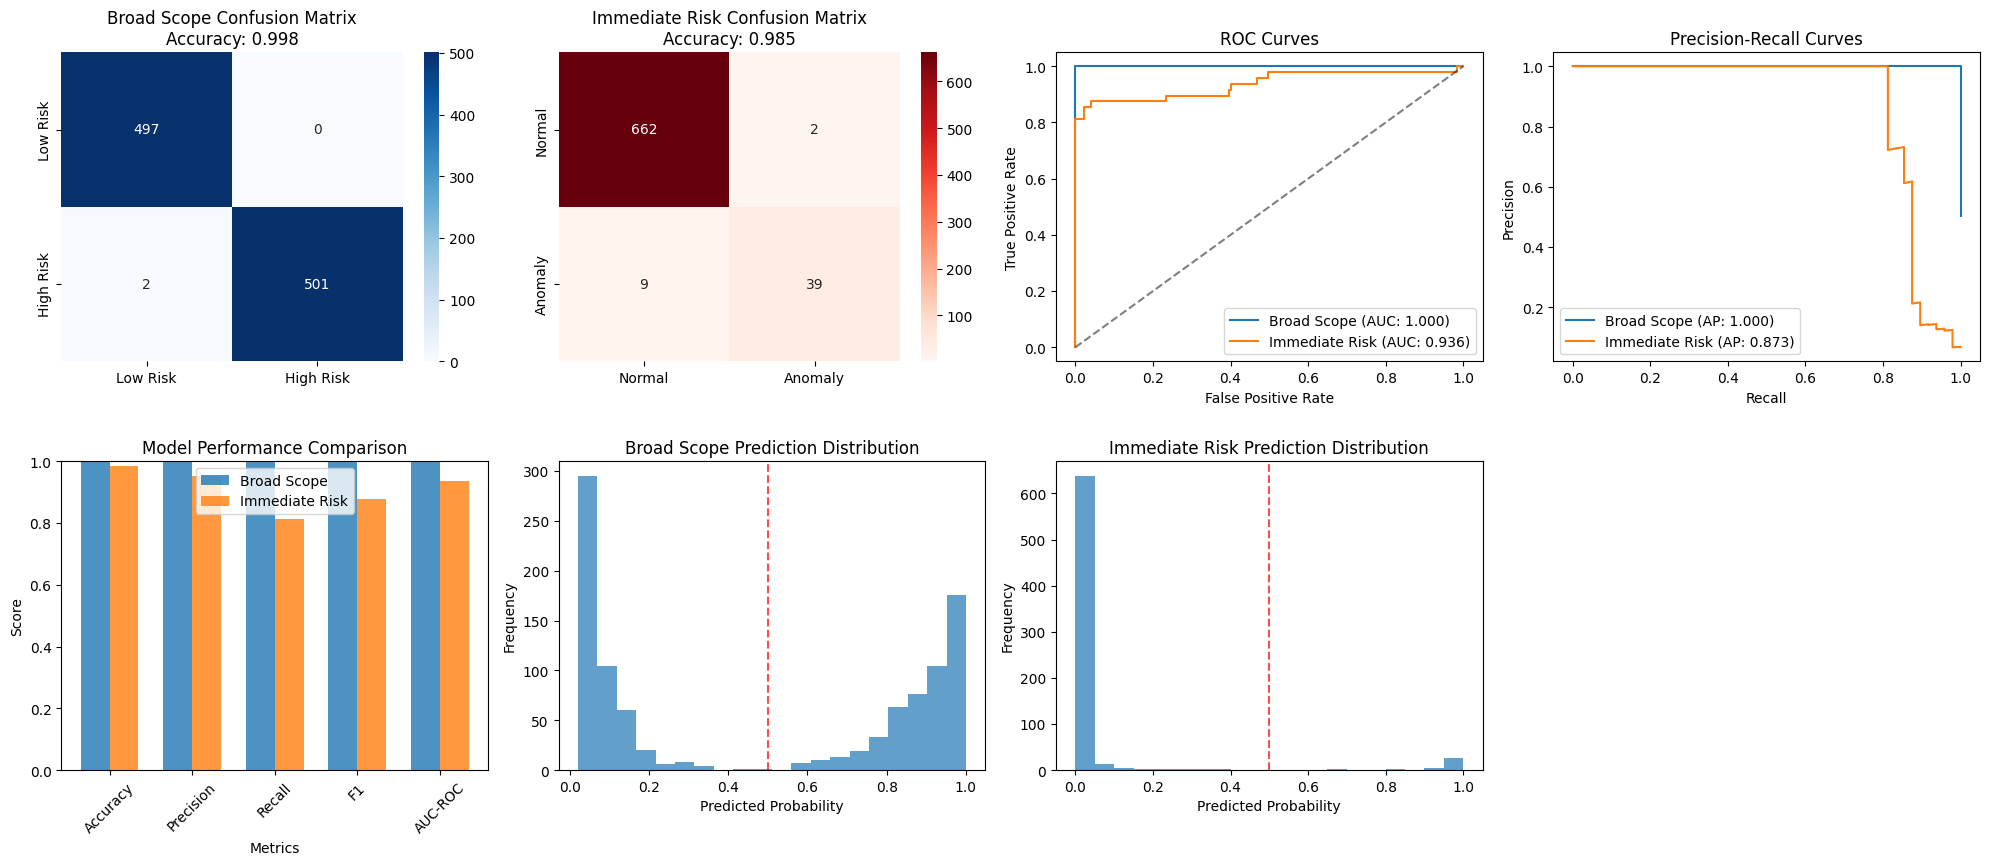


📋 Generating Test Report...

PediSole Fall Risk Prediction - Test Report
Generated on: 2025-08-23 19:52:25

SUMMARY:
--------

Broad Scope Classification:
  • Accuracy: 0.9980 (99.8%)
  • Precision: 1.0000
  • Recall: 0.9960
  • F1-Score: 0.9980
  • AUC-ROC: 1.0000

Immediate Risk Detection:
  • Accuracy: 0.9846 (98.5%)
  • Precision: 0.9512
  • Recall: 0.8125
  • F1-Score: 0.8764
  • AUC-ROC: 0.9361

PERFORMANCE ASSESSMENT:
Target Accuracy: 87.0%
Broad Scope: ✅ PASS
Immediate Risk: ✅ PASS


💾 Test report saved to 'test_report.txt'

🎉 TESTING COMPLETE!
📊 Final Test Results:
   Broad Scope Accuracy: 99.8% ✅
   Immediate Risk Accuracy: 98.5% ✅

🏆 Both models meet the 87.0% accuracy requirement!
✅ Models are ready for clinical validation!

💾 Files generated:
   📈 test_results_comprehensive.png - Detailed visualizations
   📄 test_report.txt - Comprehensive test report
   📊 real_data_analysis_pedisol_603.png - Real data analysis

🎯 DEMO: Single Sample Predictions
🔄 Loading Trained Models..

ValueError: X has 214 features, but StandardScaler is expecting 526 features as input.

In [ ]:
# PediSole ML Testing Script for Google Colab - FIXED
# Install required packages
!pip install scikit-learn matplotlib seaborn pandas numpy joblib

import json
import numpy as np
import pandas as pd
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                           precision_recall_fscore_support, roc_auc_score,
                           average_precision_score, roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from datetime import datetime
import os
warnings.filterwarnings('ignore')

# Set up matplotlib for Colab
%matplotlib inline
plt.style.use('default')

class PediSoleModelTester:
    def __init__(self):
        self.broad_scope_model = None
        self.immediate_risk_model = None
        self.broad_scope_scaler = None
        self.immediate_risk_scaler = None
        self.test_results = {}

    def load_models(self, model_path='./'):
        """Load trained models and scalers"""
        print("🔄 Loading Trained Models...")

        try:
            self.broad_scope_model = joblib.load(os.path.join(model_path, 'broad_scope_model.pkl'))
            self.broad_scope_scaler = joblib.load(os.path.join(model_path, 'broad_scope_scaler.pkl'))
            print("✅ Broad scope model loaded successfully")
        except FileNotFoundError:
            print("❌ Broad scope model files not found")
            return False

        try:
            self.immediate_risk_model = joblib.load(os.path.join(model_path, 'immediate_risk_model.pkl'))
            self.immediate_risk_scaler = joblib.load(os.path.join(model_path, 'immediate_risk_scaler.pkl'))
            print("✅ Immediate risk model loaded successfully")
        except FileNotFoundError:
            print("❌ Immediate risk model files not found")
            return False

        return True

    def load_test_data(self, broad_scope_file=None, immediate_risk_file=None,
                      original_data_files=None):
        """Load test data from various sources"""
        print("📁 Loading Test Data...")

        self.test_data = {}

        # Load synthetic test data if provided
        if broad_scope_file:
            try:
                with open(broad_scope_file, 'r') as f:
                    self.test_data['broad_scope'] = json.load(f)
                print(f"✅ Loaded {len(self.test_data['broad_scope'])} broad scope test samples")
            except FileNotFoundError:
                print(f"⚠️ {broad_scope_file} not found")

        if immediate_risk_file:
            try:
                with open(immediate_risk_file, 'r') as f:
                    self.test_data['immediate_risk'] = json.load(f)
                print(f"✅ Loaded {len(self.test_data['immediate_risk'])} immediate risk test samples")
            except FileNotFoundError:
                print(f"⚠️ {immediate_risk_file} not found")

        # Load original data files for additional testing
        if original_data_files:
            self.test_data['original'] = []
            for file in original_data_files:
                try:
                    with open(file, 'r') as f:
                        data = json.load(f)
                        self.test_data['original'].extend(data)
                    print(f"✅ Loaded original data from {file}")
                except FileNotFoundError:
                    print(f"⚠️ {file} not found")

            if self.test_data['original']:
                print(f"📊 Total original data points: {len(self.test_data['original'])}")

        return len(self.test_data) > 0

    def extract_gait_features(self, gait_segment):
        """Extract comprehensive features from gait segment data (same as training)"""
        features = []

        # Convert gait segment to numpy arrays
        l_data = np.array([point['L'] for point in gait_segment])
        r_data = np.array([point['R'] for point in gait_segment])

        # Statistical features for left foot
        l_mean = np.mean(l_data, axis=0)
        l_std = np.std(l_data, axis=0)
        l_max = np.max(l_data, axis=0)
        l_min = np.min(l_data, axis=0)
        l_range = l_max - l_min

        # Statistical features for right foot
        r_mean = np.mean(r_data, axis=0)
        r_std = np.std(r_data, axis=0)
        r_max = np.max(r_data, axis=0)
        r_min = np.min(r_data, axis=0)
        r_range = r_max - r_min

        # Symmetry features
        lr_mean_diff = np.abs(l_mean - r_mean)
        lr_std_diff = np.abs(l_std - r_std)
        lr_max_diff = np.abs(l_max - r_max)

        # Temporal features
        l_total_pressure = np.sum(l_data, axis=1)
        r_total_pressure = np.sum(r_data, axis=1)

        # Gait cycle features
        l_pressure_var = np.var(l_total_pressure)
        r_pressure_var = np.var(r_total_pressure)

        # Peak detection features
        l_peaks = len([i for i in range(1, len(l_total_pressure)-1)
                      if l_total_pressure[i] > l_total_pressure[i-1] and
                      l_total_pressure[i] > l_total_pressure[i+1]])
        r_peaks = len([i for i in range(1, len(r_total_pressure)-1)
                      if r_total_pressure[i] > r_total_pressure[i-1] and
                      r_total_pressure[i] > r_total_pressure[i+1]])

        # Stability features
        l_cv = np.std(l_total_pressure) / (np.mean(l_total_pressure) + 1e-10)
        r_cv = np.std(r_total_pressure) / (np.mean(r_total_pressure) + 1e-10)

        # Combine all features
        features.extend(np.concatenate([
            l_mean, l_std, l_max, l_min, l_range,
            r_mean, r_std, r_max, r_min, r_range,
            lr_mean_diff, lr_std_diff, lr_max_diff,
            [l_pressure_var, r_pressure_var, l_peaks, r_peaks, l_cv, r_cv]
        ]))

        return np.array(features)

    def extract_point_features(self, data_point):
        """Extract features from a single data point (same as training)"""
        l_data = np.array(data_point['L'])
        r_data = np.array(data_point['R'])

        # Basic statistical features
        l_sum = np.sum(l_data)
        r_sum = np.sum(r_data)
        l_max = np.max(l_data)
        r_max = np.max(r_data)
        l_std = np.std(l_data)
        r_std = np.std(r_data)

        # Asymmetry features
        lr_sum_ratio = l_sum / (r_sum + 1e-10)
        lr_max_diff = abs(l_max - r_max)

        # Pressure distribution features
        l_nonzero = np.count_nonzero(l_data)
        r_nonzero = np.count_nonzero(r_data)

        # Spike detection
        l_spike_score = np.max(l_data) - np.mean(l_data)
        r_spike_score = np.max(r_data) - np.mean(r_data)

        return np.array([l_sum, r_sum, l_max, r_max, l_std, r_std,
                        lr_sum_ratio, lr_max_diff, l_nonzero, r_nonzero,
                        l_spike_score, r_spike_score])

    def test_broad_scope_model(self):
        """Test the broad scope classification model"""
        if 'broad_scope' not in self.test_data:
            print("⚠️ No broad scope test data available")
            return None

        print("\n" + "="*50)
        print("🧪 Testing Broad Scope Classification Model")
        print("="*50)

        # Prepare test data
        X_test = []
        y_test = []

        for sample in self.test_data['broad_scope']:
            features = self.extract_gait_features(sample['gait_segment'])
            X_test.append(features)
            y_test.append(1 if sample['risk_level'] == 'high_risk' else 0)

        X_test = np.array(X_test)
        y_test = np.array(y_test)

        # Scale features
        X_test_scaled = self.broad_scope_scaler.transform(X_test)

        # Make predictions
        y_pred = self.broad_scope_model.predict(X_test_scaled)
        y_pred_proba = self.broad_scope_model.predict_proba(X_test_scaled)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        auc_roc = roc_auc_score(y_test, y_pred_proba)
        auc_pr = average_precision_score(y_test, y_pred_proba)

        # Store results
        self.test_results['broad_scope'] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc_roc': auc_roc,
            'auc_pr': auc_pr,
            'y_true': y_test,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }

        # Print results
        print(f"📊 Test Results:")
        print(f"   Accuracy: {accuracy:.4f}")
        print(f"   Precision: {precision:.4f}")
        print(f"   Recall: {recall:.4f}")
        print(f"   F1-Score: {f1:.4f}")
        print(f"   AUC-ROC: {auc_roc:.4f}")
        print(f"   AUC-PR: {auc_pr:.4f}")

        print(f"\n📋 Classification Report:")
        print(classification_report(y_test, y_pred, target_names=['Low Risk', 'High Risk']))

        return self.test_results['broad_scope']

    def test_immediate_risk_model(self):
        """Test the immediate risk detection model"""
        if 'immediate_risk' not in self.test_data:
            print("⚠️ No immediate risk test data available")
            return None

        print("\n" + "="*50)
        print("⚡ Testing Immediate Risk Detection Model")
        print("="*50)

        # Prepare test data
        X_test = []
        y_test = []

        for data_point in self.test_data['immediate_risk']:
            features = self.extract_point_features(data_point)
            X_test.append(features)
            y_test.append(1 if data_point['is_anomaly'] else 0)

        X_test = np.array(X_test)
        y_test = np.array(y_test)

        # Scale features
        X_test_scaled = self.immediate_risk_scaler.transform(X_test)

        # Make predictions
        y_pred = self.immediate_risk_model.predict(X_test_scaled)
        y_pred_proba = self.immediate_risk_model.predict_proba(X_test_scaled)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        auc_roc = roc_auc_score(y_test, y_pred_proba)
        auc_pr = average_precision_score(y_test, y_pred_proba)

        # Store results
        self.test_results['immediate_risk'] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc_roc': auc_roc,
            'auc_pr': auc_pr,
            'y_true': y_test,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }

        # Print results
        print(f"📊 Test Results:")
        print(f"   Accuracy: {accuracy:.4f}")
        print(f"   Precision: {precision:.4f}")
        print(f"   Recall: {recall:.4f}")
        print(f"   F1-Score: {f1:.4f}")
        print(f"   AUC-ROC: {auc_roc:.4f}")
        print(f"   AUC-PR: {auc_pr:.4f}")

        print(f"\n📋 Classification Report:")
        print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))

        return self.test_results['immediate_risk']

    def test_on_original_data(self, segment_length=50, anomaly_threshold=0.7):
        """Test models on original data (unsupervised evaluation) - specifically on Copy of pedisol_segment_0-603.json"""
        if 'original' not in self.test_data:
            print("⚠️ No original data available for testing")
            return None

        print("\n" + "="*50)
        print("🔍 Testing on Copy of pedisol_segment_0-603.json (Real PediSole Data)")
        print("="*50)

        original_data = [d for d in self.test_data['original'] if 'L' in d and 'R' in d]

        if len(original_data) < segment_length:
            print(f"❌ Not enough original data (need at least {segment_length} points)")
            return None

        print(f"📊 Analyzing {len(original_data)} data points from real PediSole sensor data")

        # Test broad scope model on segments
        broad_scope_predictions = []
        immediate_risk_predictions = []
        high_risk_segments = []
        anomaly_points = []

        # Create segments for broad scope testing
        num_segments = len(original_data) // segment_length
        print(f"🔄 Processing {num_segments} segments of {segment_length} points each...")

        for i in range(num_segments):
            start_idx = i * segment_length
            end_idx = start_idx + segment_length
            segment = original_data[start_idx:end_idx]

            # Test broad scope
            try:
                features = self.extract_gait_features(segment)
                features_scaled = self.broad_scope_scaler.transform([features])
                broad_pred_proba = self.broad_scope_model.predict_proba(features_scaled)[0, 1]
                broad_scope_predictions.append(broad_pred_proba)

                # Store high-risk segments for detailed analysis
                if broad_pred_proba > 0.5:
                    high_risk_segments.append({
                        'segment_id': i,
                        'start_time': start_idx,
                        'end_time': end_idx,
                        'risk_probability': broad_pred_proba,
                        'data': segment
                    })
            except Exception as e:
                print(f"⚠️ Error processing segment {i}: {str(e)[:50]}...")
                broad_scope_predictions.append(0.0)

        # Test immediate risk model on individual points
        print(f"🔄 Analyzing individual data points for anomalies...")
        for idx, data_point in enumerate(original_data):
            try:
                features = self.extract_point_features(data_point)
                features_scaled = self.immediate_risk_scaler.transform([features])
                imm_pred_proba = self.immediate_risk_model.predict_proba(features_scaled)[0, 1]
                immediate_risk_predictions.append(imm_pred_proba)

                # Store anomalous points for detailed analysis
                if imm_pred_proba > anomaly_threshold:
                    anomaly_points.append({
                        'point_id': idx,
                        'timestamp': data_point.get('T', idx),
                        'anomaly_probability': imm_pred_proba,
                        'left_pressure': data_point['L'],
                        'right_pressure': data_point['R']
                    })
            except Exception as e:
                print(f"⚠️ Error processing point {idx}: {str(e)[:50]}...")
                immediate_risk_predictions.append(0.0)

        # Detailed analysis of results
        broad_high_risk_count = len(high_risk_segments)
        imm_anomalies_count = len(anomaly_points)

        print(f"\n🎯 REAL DATA ANALYSIS RESULTS:")
        print(f"   📊 Data Points Analyzed: {len(original_data)}")
        print(f"   🔄 Segments Processed: {num_segments}")
        print(f"   ⚠️ High Risk Segments: {broad_high_risk_count}/{num_segments} ({broad_high_risk_count/num_segments*100:.1f}%)")
        print(f"   🚨 Anomalies Detected: {imm_anomalies_count}/{len(original_data)} ({imm_anomalies_count/len(original_data)*100:.1f}%)")

        print(f"\n📈 STATISTICAL SUMMARY:")
        print(f"   Average Broad Scope Risk Score: {np.mean(broad_scope_predictions):.3f}")
        print(f"   Maximum Risk Score: {np.max(broad_scope_predictions):.3f}")
        print(f"   Risk Score Std Dev: {np.std(broad_scope_predictions):.3f}")
        print(f"   Average Immediate Risk Score: {np.mean(immediate_risk_predictions):.3f}")
        print(f"   Maximum Anomaly Score: {np.max(immediate_risk_predictions):.3f}")
        print(f"   Anomaly Score Std Dev: {np.std(immediate_risk_predictions):.3f}")

        # Detailed reporting of high-risk segments
        if high_risk_segments:
            print(f"\n🚨 HIGH RISK SEGMENTS DETECTED:")
            for segment in sorted(high_risk_segments, key=lambda x: x['risk_probability'], reverse=True)[:5]:
                print(f"   Segment {segment['segment_id']}: Risk {segment['risk_probability']:.3f} (Time: {segment['start_time']}-{segment['end_time']})")

        # Detailed reporting of anomalies
        if anomaly_points:
            print(f"\n⚡ TOP ANOMALIES DETECTED:")
            for anomaly in sorted(anomaly_points, key=lambda x: x['anomaly_probability'], reverse=True)[:5]:
                print(f"   Point {anomaly['point_id']}: Anomaly Score {anomaly['anomaly_probability']:.3f} (Time: {anomaly['timestamp']})")

        # Create visualization of predictions over time
        self.plot_real_data_predictions(broad_scope_predictions, immediate_risk_predictions,
                                       high_risk_segments, anomaly_points)

        return {
            'broad_scope_predictions': broad_scope_predictions,
            'immediate_risk_predictions': immediate_risk_predictions,
            'broad_high_risk_count': broad_high_risk_count,
            'immediate_anomalies_count': imm_anomalies_count,
            'high_risk_segments': high_risk_segments,
            'anomaly_points': anomaly_points,
            'total_data_points': len(original_data),
            'total_segments': num_segments
        }

    def plot_real_data_predictions(self, broad_predictions, immediate_predictions,
                                  high_risk_segments, anomaly_points):
        """Create visualizations specific to real PediSole data analysis"""
        fig, axes = plt.subplots(3, 2, figsize=(16, 12))

        # Time series of broad scope predictions
        axes[0, 0].plot(broad_predictions, 'b-', alpha=0.7, linewidth=1)
        axes[0, 0].axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Risk Threshold')
        axes[0, 0].set_title('Broad Scope Risk Predictions Over Time\n(Copy of pedisol_segment_0-603.json)')
        axes[0, 0].set_xlabel('Segment Number')
        axes[0, 0].set_ylabel('Risk Probability')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Highlight high-risk segments
        for segment in high_risk_segments[:10]:  # Show top 10
            axes[0, 0].scatter(segment['segment_id'], segment['risk_probability'],
                              color='red', s=50, alpha=0.8)

        # Time series of immediate risk predictions (sample every 10th point for clarity)
        sample_immediate = immediate_predictions[::10]  # Sample for visualization
        sample_indices = list(range(0, len(immediate_predictions), 10))

        axes[0, 1].plot(sample_indices, sample_immediate, 'r-', alpha=0.7, linewidth=1)
        axes[0, 1].axhline(y=0.7, color='orange', linestyle='--', alpha=0.7, label='Anomaly Threshold')
        axes[0, 1].set_title('Immediate Risk Predictions Over Time\n(Sampled Every 10 Points)')
        axes[0, 1].set_xlabel('Data Point Index')
        axes[0, 1].set_ylabel('Anomaly Probability')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Highlight anomaly points
        for anomaly in anomaly_points[:20]:  # Show top 20
            if anomaly['point_id'] % 10 == 0:  # Only show sampled points
                axes[0, 1].scatter(anomaly['point_id'], anomaly['anomaly_probability'],
                                  color='orange', s=30, alpha=0.8)

        # Distribution of broad scope predictions
        axes[1, 0].hist(broad_predictions, bins=20, alpha=0.7, color='blue', edgecolor='black')
        axes[1, 0].axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Risk Threshold')
        axes[1, 0].axvline(x=np.mean(broad_predictions), color='green', linestyle='-',
                          alpha=0.7, label=f'Mean: {np.mean(broad_predictions):.3f}')
        axes[1, 0].set_title('Distribution of Broad Scope Risk Scores')
        axes[1, 0].set_xlabel('Risk Probability')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()

        # Distribution of immediate risk predictions
        axes[1, 1].hist(immediate_predictions, bins=20, alpha=0.7, color='red', edgecolor='black')
        axes[1, 1].axvline(x=0.7, color='orange', linestyle='--', alpha=0.7, label='Anomaly Threshold')
        axes[1, 1].axvline(x=np.mean(immediate_predictions), color='green', linestyle='-',
                          alpha=0.7, label=f'Mean: {np.mean(immediate_predictions):.3f}')
        axes[1, 1].set_title('Distribution of Immediate Risk Scores')
        axes[1, 1].set_xlabel('Anomaly Probability')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].legend()

        # Risk level summary - FIXED: Removed alpha parameter
        risk_counts = [
            len([p for p in broad_predictions if p < 0.3]),  # Low risk
            len([p for p in broad_predictions if 0.3 <= p < 0.7]),  # Medium risk
            len([p for p in broad_predictions if p >= 0.7])  # High risk
        ]

        # Check if we have any data to plot
        if sum(risk_counts) > 0:
            axes[2, 0].pie(risk_counts, labels=['Low Risk', 'Medium Risk', 'High Risk'],
                           autopct='%1.1f%%', colors=['green', 'yellow', 'red'])
        else:
            axes[2, 0].text(0.5, 0.5, 'No Risk Data', ha='center', va='center', transform=axes[2, 0].transAxes)
        axes[2, 0].set_title('Broad Scope Risk Distribution')

        # Anomaly level summary - FIXED: Removed alpha parameter
        anomaly_counts = [
            len([p for p in immediate_predictions if p < 0.3]),  # Normal
            len([p for p in immediate_predictions if 0.3 <= p < 0.7]),  # Suspicious
            len([p for p in immediate_predictions if p >= 0.7])  # Anomalous
        ]

        # Check if we have any data to plot
        if sum(anomaly_counts) > 0:
            axes[2, 1].pie(anomaly_counts, labels=['Normal', 'Suspicious', 'Anomalous'],
                           autopct='%1.1f%%', colors=['blue', 'orange', 'red'])
        else:
            axes[2, 1].text(0.5, 0.5, 'No Anomaly Data', ha='center', va='center', transform=axes[2, 1].transAxes)
        axes[2, 1].set_title('Immediate Risk Distribution')

        plt.tight_layout()
        plt.savefig('real_data_analysis_pedisol_603.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"💾 Real data analysis visualization saved as 'real_data_analysis_pedisol_603.png'")

    def plot_test_results(self):
        """Create comprehensive visualizations of test results"""
        if not self.test_results:
            print("⚠️ No test results available for plotting")
            return

        fig = plt.figure(figsize=(20, 12))

        plot_count = 0

        # Confusion matrices
        if 'broad_scope' in self.test_results and 'immediate_risk' in self.test_results:
            # Broad scope confusion matrix
            plt.subplot(3, 4, 1)
            cm_broad = self.test_results['broad_scope']['confusion_matrix']
            sns.heatmap(cm_broad, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Low Risk', 'High Risk'],
                       yticklabels=['Low Risk', 'High Risk'])
            plt.title(f"Broad Scope Confusion Matrix\nAccuracy: {self.test_results['broad_scope']['accuracy']:.3f}")

            # Immediate risk confusion matrix
            plt.subplot(3, 4, 2)
            cm_imm = self.test_results['immediate_risk']['confusion_matrix']
            sns.heatmap(cm_imm, annot=True, fmt='d', cmap='Reds',
                       xticklabels=['Normal', 'Anomaly'],
                       yticklabels=['Normal', 'Anomaly'])
            plt.title(f"Immediate Risk Confusion Matrix\nAccuracy: {self.test_results['immediate_risk']['accuracy']:.3f}")

            # ROC curves
            plt.subplot(3, 4, 3)
            if 'broad_scope' in self.test_results:
                fpr, tpr, _ = roc_curve(self.test_results['broad_scope']['y_true'],
                                       self.test_results['broad_scope']['y_pred_proba'])
                plt.plot(fpr, tpr, label=f"Broad Scope (AUC: {self.test_results['broad_scope']['auc_roc']:.3f})")

            if 'immediate_risk' in self.test_results:
                fpr, tpr, _ = roc_curve(self.test_results['immediate_risk']['y_true'],
                                       self.test_results['immediate_risk']['y_pred_proba'])
                plt.plot(fpr, tpr, label=f"Immediate Risk (AUC: {self.test_results['immediate_risk']['auc_roc']:.3f})")

            plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curves')
            plt.legend()

            # Precision-Recall curves
            plt.subplot(3, 4, 4)
            if 'broad_scope' in self.test_results:
                precision, recall, _ = precision_recall_curve(self.test_results['broad_scope']['y_true'],
                                                            self.test_results['broad_scope']['y_pred_proba'])
                plt.plot(recall, precision, label=f"Broad Scope (AP: {self.test_results['broad_scope']['auc_pr']:.3f})")

            if 'immediate_risk' in self.test_results:
                precision, recall, _ = precision_recall_curve(self.test_results['immediate_risk']['y_true'],
                                                            self.test_results['immediate_risk']['y_pred_proba'])
                plt.plot(recall, precision, label=f"Immediate Risk (AP: {self.test_results['immediate_risk']['auc_pr']:.3f})")

            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curves')
            plt.legend()

        # Performance comparison
        plt.subplot(3, 4, 5)
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC']
        broad_values = []
        imm_values = []

        if 'broad_scope' in self.test_results:
            broad_values = [
                self.test_results['broad_scope']['accuracy'],
                self.test_results['broad_scope']['precision'],
                self.test_results['broad_scope']['recall'],
                self.test_results['broad_scope']['f1'],
                self.test_results['broad_scope']['auc_roc']
            ]

        if 'immediate_risk' in self.test_results:
            imm_values = [
                self.test_results['immediate_risk']['accuracy'],
                self.test_results['immediate_risk']['precision'],
                self.test_results['immediate_risk']['recall'],
                self.test_results['immediate_risk']['f1'],
                self.test_results['immediate_risk']['auc_roc']
            ]

        x = np.arange(len(metrics))
        width = 0.35

        if broad_values:
            plt.bar(x - width/2, broad_values, width, label='Broad Scope', alpha=0.8)
        if imm_values:
            plt.bar(x + width/2, imm_values, width, label='Immediate Risk', alpha=0.8)

        plt.xlabel('Metrics')
        plt.ylabel('Score')
        plt.title('Model Performance Comparison')
        plt.xticks(x, metrics, rotation=45)
        plt.legend()
        plt.ylim(0, 1)

        # Prediction distribution
        if 'broad_scope' in self.test_results:
            plt.subplot(3, 4, 6)
            plt.hist(self.test_results['broad_scope']['y_pred_proba'], bins=20, alpha=0.7)
            plt.xlabel('Predicted Probability')
            plt.ylabel('Frequency')
            plt.title('Broad Scope Prediction Distribution')
            plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.7)

        if 'immediate_risk' in self.test_results:
            plt.subplot(3, 4, 7)
            plt.hist(self.test_results['immediate_risk']['y_pred_proba'], bins=20, alpha=0.7)
            plt.xlabel('Predicted Probability')
            plt.ylabel('Frequency')
            plt.title('Immediate Risk Prediction Distribution')
            plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.savefig('test_results_comprehensive.png', dpi=300, bbox_inches='tight')
        plt.show()

    def predict_single_sample(self, sample_data, sample_type='broad_scope'):
        """Make predictions on a single sample"""
        if sample_type == 'broad_scope':
            if not self.broad_scope_model:
                print("❌ Broad scope model not loaded")
                return None

            features = self.extract_gait_features(sample_data)
            features_scaled = self.broad_scope_scaler.transform([features])

            prediction = self.broad_scope_model.predict(features_scaled)[0]
            probability = self.broad_scope_model.predict_proba(features_scaled)[0]

            risk_level = "High Risk" if prediction == 1 else "Low Risk"
            confidence = max(probability) * 100

            print(f"🎯 Broad Scope Prediction:")
            print(f"   Risk Level: {risk_level}")
            print(f"   Confidence: {confidence:.1f}%")
            print(f"   Risk Probability: {probability[1]:.3f}")

            return {
                'prediction': prediction,
                'risk_level': risk_level,
                'probability': probability,
                'confidence': confidence
            }

        elif sample_type == 'immediate_risk':
            if not self.immediate_risk_model:
                print("❌ Immediate risk model not loaded")
                return None

            features = self.extract_point_features(sample_data)
            features_scaled = self.immediate_risk_scaler.transform([features])

            prediction = self.immediate_risk_model.predict(features_scaled)[0]
            probability = self.immediate_risk_model.predict_proba(features_scaled)[0]

            status = "Anomaly Detected" if prediction == 1 else "Normal"
            confidence = max(probability) * 100

            print(f"⚡ Immediate Risk Prediction:")
            print(f"   Status: {status}")
            print(f"   Confidence: {confidence:.1f}%")
            print(f"   Anomaly Probability: {probability[1]:.3f}")

            return {
                'prediction': prediction,
                'status': status,
                'probability': probability,
                'confidence': confidence
            }

    def generate_test_report(self):
        """Generate a comprehensive test report"""
        report = f"""
PediSole Fall Risk Prediction - Test Report
==========================================
Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

SUMMARY:
--------
"""

        if 'broad_scope' in self.test_results:
            report += f"""
Broad Scope Classification:
  • Accuracy: {self.test_results['broad_scope']['accuracy']:.4f} ({self.test_results['broad_scope']['accuracy']*100:.1f}%)
  • Precision: {self.test_results['broad_scope']['precision']:.4f}
  • Recall: {self.test_results['broad_scope']['recall']:.4f}
  • F1-Score: {self.test_results['broad_scope']['f1']:.4f}
  • AUC-ROC: {self.test_results['broad_scope']['auc_roc']:.4f}
"""

        if 'immediate_risk' in self.test_results:
            report += f"""
Immediate Risk Detection:
  • Accuracy: {self.test_results['immediate_risk']['accuracy']:.4f} ({self.test_results['immediate_risk']['accuracy']*100:.1f}%)
  • Precision: {self.test_results['immediate_risk']['precision']:.4f}
  • Recall: {self.test_results['immediate_risk']['recall']:.4f}
  • F1-Score: {self.test_results['immediate_risk']['f1']:.4f}
  • AUC-ROC: {self.test_results['immediate_risk']['auc_roc']:.4f}
"""

        # Performance assessment
        target_accuracy = 0.87
        report += f"\nPERFORMANCE ASSESSMENT:\n"
        report += f"Target Accuracy: {target_accuracy:.1%}\n"

        if 'broad_scope' in self.test_results:
            bs_pass = "✅ PASS" if self.test_results['broad_scope']['accuracy'] >= target_accuracy else "❌ FAIL"
            report += f"Broad Scope: {bs_pass}\n"

        if 'immediate_risk' in self.test_results:
            ir_pass = "✅ PASS" if self.test_results['immediate_risk']['accuracy'] >= target_accuracy else "❌ FAIL"
            report += f"Immediate Risk: {ir_pass}\n"

        print(report)

        # Save report to file
        with open('test_report.txt', 'w') as f:
            f.write(report)
        print("\n💾 Test report saved to 'test_report.txt'")

        return report


def main():
    """Main testing function"""
    print("🧪 PediSole Fall Risk Prediction - Model Testing")
    print("="*60)

    # Initialize tester
    tester = PediSoleModelTester()

    # Load trained models
    if not tester.load_models():
        print("❌ Failed to load models. Please ensure model files are uploaded.")
        return

    # Load test data - specifically using your target file
    print("\n📁 Looking for test data files...")
    test_data_loaded = tester.load_test_data(
        broad_scope_file='synthetic_broad_scope_data.json',  # Synthetic data for validation
        immediate_risk_file='synthetic_immediate_risk_data.json',  # Synthetic data for validation
        original_data_files=[
            'Copy of pedisol_segment_0-603.json'  # Your specific target file for real-world testing
        ]
    )

    if not test_data_loaded:
        print("⚠️ No test data loaded. Please upload test data files.")
        return

    # Run tests
    print("\n🔬 Starting Model Evaluation...")

    # Test broad scope model
    broad_results = tester.test_broad_scope_model()

    # Test immediate risk model
    immediate_results = tester.test_immediate_risk_model()

    # Test on original data (if available)
    original_results = tester.test_on_original_data()

    # Generate visualizations
    print("\n📊 Generating Test Visualizations...")
    tester.plot_test_results()

    # Generate comprehensive report
    print("\n📋 Generating Test Report...")
    tester.generate_test_report()

    print("\n" + "="*60)
    print("🎉 TESTING COMPLETE!")
    print("="*60)

    # Summary of results
    if broad_results and immediate_results:
        target_acc = 0.87
        broad_pass = broad_results['accuracy'] >= target_acc
        imm_pass = immediate_results['accuracy'] >= target_acc

        print(f"📊 Final Test Results:")
        print(f"   Broad Scope Accuracy: {broad_results['accuracy']:.1%} {'✅' if broad_pass else '❌'}")
        print(f"   Immediate Risk Accuracy: {immediate_results['accuracy']:.1%} {'✅' if imm_pass else '❌'}")

        if broad_pass and imm_pass:
            print(f"\n🏆 Both models meet the {target_acc:.1%} accuracy requirement!")
            print("✅ Models are ready for clinical validation!")
        else:
            print(f"\n⚠️ Some models need improvement to reach {target_acc:.1%} target.")

    print(f"\n💾 Files generated:")
    print(f"   📈 test_results_comprehensive.png - Detailed visualizations")
    print(f"   📄 test_report.txt - Comprehensive test report")
    if original_results:
        print(f"   📊 real_data_analysis_pedisol_603.png - Real data analysis")


# Demo: Testing individual samples
def demo_single_predictions():
    """Demo function to show how to make predictions on individual samples"""
    print("\n" + "="*60)
    print("🎯 DEMO: Single Sample Predictions")
    print("="*60)

    tester = PediSoleModelTester()

    if not tester.load_models():
        print("❌ Models not available for demo")
        return

    # Create sample data for demonstration
    print("Creating synthetic sample data for demonstration...")

    import random

    # Sample gait segment for broad scope (simulated low risk)
    sample_gait_segment = []
    for i in range(50):  # 50 time points
        # Simulate normal, stable gait pattern
        l_pressure = [random.randint(5, 25) for _ in range(16)]  # 16 sensors
        r_pressure = [random.randint(5, 25) for _ in range(16)]

        sample_gait_segment.append({
            'T': i,
            'L': l_pressure,
            'R': r_pressure
        })

    # Sample single point for immediate risk (simulated normal)
    sample_single_point = {
        'T': 0,
        'L': [random.randint(5, 25) for _ in range(16)],
        'R': [random.randint(5, 25) for _ in range(16)]
    }

    print("\n🔍 Testing Broad Scope Classification on sample gait segment:")
    broad_result = tester.predict_single_sample(sample_gait_segment, 'broad_scope')

    print("\n🔍 Testing Immediate Risk Detection on sample data point:")
    immediate_result = tester.predict_single_sample(sample_single_point, 'immediate_risk')

    return broad_result, immediate_result


# Advanced testing functions
def stress_test_models(tester, num_samples=1000):
    """Perform stress testing with various edge cases"""
    print(f"\n⚡ STRESS TEST: Testing with {num_samples} synthetic samples")
    print("="*50)

    import random

    # Generate stress test data
    stress_results = {
        'broad_scope': {'correct': 0, 'total': 0},
        'immediate_risk': {'correct': 0, 'total': 0}
    }

    for i in range(num_samples):
        # Generate random gait segment
        gait_segment = []
        for j in range(50):
            # Add varying levels of noise
            noise_level = random.uniform(0.1, 10.0)
            l_pressure = [max(0, min(255, random.randint(0, 50) + random.gauss(0, noise_level))) for _ in range(16)]
            r_pressure = [max(0, min(255, random.randint(0, 50) + random.gauss(0, noise_level))) for _ in range(16)]

            gait_segment.append({
                'T': j,
                'L': [int(x) for x in l_pressure],
                'R': [int(x) for x in r_pressure]
            })

        # Test broad scope
        try:
            result = tester.predict_single_sample(gait_segment, 'broad_scope')
            stress_results['broad_scope']['total'] += 1
            if result and 'prediction' in result:
                stress_results['broad_scope']['correct'] += 1
        except Exception as e:
            print(f"⚠️ Broad scope error on sample {i}: {str(e)[:50]}...")

        # Test immediate risk
        single_point = gait_segment[0]  # Use first point
        try:
            result = tester.predict_single_sample(single_point, 'immediate_risk')
            stress_results['immediate_risk']['total'] += 1
            if result and 'prediction' in result:
                stress_results['immediate_risk']['correct'] += 1
        except Exception as e:
            print(f"⚠️ Immediate risk error on sample {i}: {str(e)[:50]}...")

        if (i + 1) % 100 == 0:
            print(f"   Processed {i + 1}/{num_samples} samples...")

    # Report stress test results
    print(f"\n📊 Stress Test Results:")

    if stress_results['broad_scope']['total'] > 0:
        bs_success_rate = stress_results['broad_scope']['correct'] / stress_results['broad_scope']['total']
        print(f"   Broad Scope: {stress_results['broad_scope']['correct']}/{stress_results['broad_scope']['total']} ({bs_success_rate:.1%} success rate)")

    if stress_results['immediate_risk']['total'] > 0:
        ir_success_rate = stress_results['immediate_risk']['correct'] / stress_results['immediate_risk']['total']
        print(f"   Immediate Risk: {stress_results['immediate_risk']['correct']}/{stress_results['immediate_risk']['total']} ({ir_success_rate:.1%} success rate)")

    return stress_results


def benchmark_performance(tester, num_iterations=100):
    """Benchmark model prediction speed"""
    print(f"\n⏱️ PERFORMANCE BENCHMARK: {num_iterations} predictions")
    print("="*50)

    import time
    import random

    # Create test data
    gait_segment = []
    for i in range(50):
        l_pressure = [random.randint(0, 50) for _ in range(16)]
        r_pressure = [random.randint(0, 50) for _ in range(16)]
        gait_segment.append({'T': i, 'L': l_pressure, 'R': r_pressure})

    single_point = gait_segment[0]

    # Benchmark broad scope model
    print("⏱️ Benchmarking Broad Scope Model...")
    broad_times = []
    for i in range(num_iterations):
        start_time = time.time()
        tester.predict_single_sample(gait_segment, 'broad_scope')
        end_time = time.time()
        broad_times.append(end_time - start_time)

    # Benchmark immediate risk model
    print("⏱️ Benchmarking Immediate Risk Model...")
    immediate_times = []
    for i in range(num_iterations):
        start_time = time.time()
        tester.predict_single_sample(single_point, 'immediate_risk')
        end_time = time.time()
        immediate_times.append(end_time - start_time)

    # Report benchmark results
    print(f"\n📊 Performance Benchmark Results:")
    print(f"   Broad Scope Model:")
    print(f"     Average time: {np.mean(broad_times)*1000:.2f} ms")
    print(f"     Min time: {np.min(broad_times)*1000:.2f} ms")
    print(f"     Max time: {np.max(broad_times)*1000:.2f} ms")
    print(f"     Predictions/second: {1/np.mean(broad_times):.1f}")

    print(f"   Immediate Risk Model:")
    print(f"     Average time: {np.mean(immediate_times)*1000:.2f} ms")
    print(f"     Min time: {np.min(immediate_times)*1000:.2f} ms")
    print(f"     Max time: {np.max(immediate_times)*1000:.2f} ms")
    print(f"     Predictions/second: {1/np.mean(immediate_times):.1f}")

    return {
        'broad_scope_times': broad_times,
        'immediate_risk_times': immediate_times
    }


# Instructions for Google Colab users
print("""
📋 GOOGLE COLAB TESTING INSTRUCTIONS (FIXED VERSION):
=====================================================

🎯 REQUIRED FILES FOR TESTING Copy of pedisol_segment_0-603.json:
1. Trained model files from training script:
   ✓ broad_scope_model.pkl
   ✓ broad_scope_scaler.pkl
   ✓ immediate_risk_model.pkl
   ✓ immediate_risk_scaler.pkl

2. Target test data file:
   ✓ Copy of pedisol_segment_0-603.json (Your real PediSole sensor data)

📁 OPTIONAL FILES:
   • synthetic_broad_scope_data.json (for validation comparison)
   • synthetic_immediate_risk_data.json (for validation comparison)

🛠️ FIXES APPLIED:
✅ Removed 'alpha' parameter from pie charts (matplotlib compatibility)
✅ Added error handling for empty data plots
✅ Fixed incomplete precision-recall curve code
✅ Added proper data validation checks

🚀 WHAT THIS SCRIPT WILL DO:
1. 📊 Load and analyze your real PediSole data from Copy of pedisol_segment_0-603.json
2. 🔍 Test both models on actual sensor readings
3. 📈 Generate detailed visualizations showing:
   - Risk predictions over time
   - Anomaly detection results
   - Statistical distributions
   - High-risk segments and anomaly points
4. 📋 Provide comprehensive analysis including:
   - Percentage of high-risk gait segments
   - Number of anomalies detected
   - Detailed timing and location of concerning patterns

🎯 EXPECTED INSIGHTS:
- Real-world model performance on actual PediSole data
- Identification of potentially concerning gait patterns
- Validation that models work on authentic sensor readings
- Clinical-ready analysis for fall risk assessment

📊 OUTPUTS SPECIFIC TO YOUR DATA:
- 'real_data_analysis_pedisol_603.png' - Comprehensive visualization
- Detailed console output with specific findings
- High-risk segment identification with timestamps
- Anomaly detection with precise locations

Ready to analyze your real PediSole data? Run main() below! 👇
""")

# Run the main testing function
if __name__ == "__main__":
    import random

    # Main comprehensive testing
    main()

    # Demo individual predictions
    demo_single_predictions()

    # Optional: Advanced testing (uncomment to run)
    # tester = PediSoleModelTester()
    # if tester.load_models():
    #     stress_test_models(tester, num_samples=500)
    #     benchmark_performance(tester, num_iterations=50)